# Data 


In [1]:
import logging 
import numpy as np
import importlib
import pandas as pd
from os.path import join
from data.data_access import Data
from preprocessing import pre
from utils.logs import set_logging
from config_path import ENH_LOG_PATH

params_file = 'train/params/P1000/pnet/onsplit_average_reg_10_tanh_large_testing.py'

log_dir = join(ENH_LOG_PATH, 'log')
log_dir = log_dir
set_logging(log_dir)

setting logs


In [2]:
loader = importlib.machinery.SourceFileLoader('params', params_file)
params = loader.load_module()   


2023-11-29 18:20:45.594838: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-29 18:20:49.404002: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-29 18:20:49.404175: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-29 18:20:49.736027: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-29 18:20:50.650698: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-29 18:20:50.665802: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
params  

<module 'params' from 'train/params/P1000/pnet/onsplit_average_reg_10_tanh_large_testing.py'>

In [4]:
data = Data(**params.data[0])

loading enh_vs_genes
loading data from /PROJECTS/Sally/PNET_py3_enh_gene/_database/enh_vs_genes/Enh_vs_Genes_matrix_number.txt,


(73347, 30781)
loading response from Enh_vs_Genes_interactions_1Oct.txt
loaded data 73347 samples, 30781 variables, 73347 responses 
30781


In [5]:
x_train, x_validate_, x_test_, y_train, y_validate_, y_test_, info_train, info_validate_, info_test_, cols = data.get_train_validate_test()

In [6]:
import csv

info_t = info_test_


In [7]:
print("x_train:", x_train.shape)
print("x_train:", y_train.shape)

print("x_validate_:", x_validate_.shape)
print("y_validate_:", y_validate_.shape)

print("x_test:", x_test_.shape)
print("y_test:", y_test_.shape)

print("columns:", len(cols))

x_train: (58677, 30781)
x_train: (58677,)
x_validate_: (7335, 30781)
y_validate_: (7335,)
x_test: (7335, 30781)
y_test: (7335,)
columns: 30781


# Model

In [8]:
from copy import deepcopy
from model import nn

In [9]:
model_params_ = deepcopy(params.models[0])

In [10]:
model = nn.Model(**model_params_['params'])

class_weight None


In [11]:
history = model.fit(x_train, y_train, x_validate_, y_validate_)

{'id': 'ALL', 'type': 'prostate_paper', 'params': {'data_type': 'enh_vs_genes', 'drop_AR': False, 'mut_binary': True, 'balanced_data': False, 'combine_type': 'union', 'use_coding_genes_only': True, 'selected_genes': None, 'training_split': 0}}
n_hidden_layers 2
loading enh_vs_genes
loading data from /PROJECTS/Sally/PNET_py3_enh_gene/_database/enh_vs_genes/Enh_vs_Genes_matrix_number.txt,
loading from memory cached_data
(73347, 30781)
loading from memory cached_data
loaded data 73347 samples, 30781 variables, 73347 responses 
30781
(73347, 30781)
(73347,)
(73347,)
(30781,)
x shape (73347, 30781) , y shape (73347,) info (73347,) genes (30781,)
x shape (73347, 30781) , y shape (73347,) info (73347,) genes (30781,)
input dimension 30781 self.units 30781
n_inputs_per_node 1.0
self.kernel_initializer <keras.src.regularizers.L2 object at 0x7fc86150cd90> <keras.src.initializers.initializers.LecunUniform object at 0x7fc847605dd0> <keras.src.regularizers.L2 object at 0x7fc86150cd90>


2023-11-29 18:36:46.097704: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


input dimensions (None, 30781)
layer # 0
pathways 146
genes 10621
filtered_map (30781, 0)
filtered_map (30781, 0)
filtered_map (30781, 0)
layer 0 , # of edges  0.0
layer # 1
pathways 26
genes 147
filtered_map (146, 0)
filtered_map (146, 0)
filtered_map (146, 0)
layer 1 , # of edges  147.0
layer # 2
pathways 1
genes 26
filtered_map (26, 0)
filtered_map (26, 0)
filtered_map (26, 0)
layer 2 , # of edges  26.0
original dropout [0.5, 0.1, 0.1, 0.1]
dropout [1, 2] [0.5, 0.1, 0.1, 0.1] [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]
n_genes, n_pathways 30781 146 
layer 0, dropout  0.1 w_reg 0.001
n_genes, n_pathways 146 26 
layer 1, dropout  0.1 w_reg 0.001
Compiling...
loss_weights [2, 7, 20, 54, 148, 400]
done compiling
  - 0 inputs [(None, 30781)]
  - 1 h0 (None, 30781)
  - 2 dropout_0 (None, 30781)
  - 3 h1 (None, 146)
  - 4 dropout_1 (None, 146)
  - 5 h2 (None, 26)
  - 6 o_linear1 (None, 1)
  - 7 o_linear2 (None, 1)
  - 8 o_linear3 (None, 1)
  - 9 o1 (None, 1)
  - 10 o2 (None, 1)
  - 1

2023-11-29 18:37:24.733241: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 14449093896 exceeds 10% of free system memory.



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/100
input dimensions (None, 30781)
input dimensions (None, 30781)
input dimensions (None, 30781)
input dimensions (None, 30781)
230/230 [==============================] - 1s 6ms/step
587/587 - 103s - loss: 19.9343 - o1_loss: 0.6040 - o2_loss: 0.6932 - o3_loss: 0.6932 - o1_f1: 0.7821 - o2_f1: 0.0910 - o3_f1: 0.1247 - val_loss: 19.7951 - val_o1_loss: 0.5343 - val_o2_loss: 0.6931 - val_o3_loss: 0.6931 - val_o1_f1: 0.4902 - val_o2_f1: 0.0000e+00 - val_o3_f1: 0.0000e+00 - lr: 0.0010 - 103s/epoch - 176ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/100
230/230 [==============================] - 1s 6ms/step
587/587 - 39s - loss: 19.6991 - o1_loss: 0.4827 - o2_loss: 0.6932 - o3_loss: 0.6932 - o1_f1: 0.8195 - o2_f1: 0.0631 - o3_f1: 0.0642 - val_loss: 19.6510 - val_o1_loss: 0.4550 - val_o2_loss: 0.6931 - val_o3_loss: 0.6931 - val_o1_f1: 0.4838 - val_o2_f1: 0.6002 - val_o3_f1: 0.6002 - lr: 0.00

2023-11-29 18:58:59.473769: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 14449093896 exceeds 10% of free system memory.


1834/1834 [==============================] - 10s 6ms/step
(58677, 1)
[0.1  0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23
 0.24 0.25 0.26 0.27 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37
 0.38 0.39 0.4  0.41 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51
 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65
 0.66 0.67 0.68 0.69 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79
 0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89]


/SOFTWARE/anaconda/[/home/DATA]/envs/Taiji-env/Sally_PNET_py3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/SOFTWARE/anaconda/[/home/DATA]/envs/Taiji-env/Sally_PNET_py3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/SOFTWARE/anaconda/[/home/DATA]/envs/Taiji-env/Sally_PNET_py3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

    accuracy  precision        f1  recall    th
0   0.498253   0.498253  0.665112     1.0  0.10
1   0.498253   0.498253  0.665112     1.0  0.11
2   0.498253   0.498253  0.665112     1.0  0.12
3   0.498253   0.498253  0.665112     1.0  0.13
4   0.498253   0.498253  0.665112     1.0  0.14
..       ...        ...       ...     ...   ...
75  0.501747   0.000000  0.000000     0.0  0.85
76  0.501747   0.000000  0.000000     0.0  0.86
77  0.501747   0.000000  0.000000     0.0  0.87
78  0.501747   0.000000  0.000000     0.0  0.88
79  0.501747   0.000000  0.000000     0.0  0.89

[80 rows x 5 columns]
prediction threshold 0.4999999999999998


230/230 [==============================] - 1s 5ms/step
(7335, 1)
230/230 [==============================] - 1s 5ms/step
(7335, 1)
(7335, 2)
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      3666
           1       0.99      0.81      0.89      3669

    accuracy                           0.90      7335
   macro avg       0.91      0.90      0.90      7335
weighted avg       0.91      0.90      0.90      7335



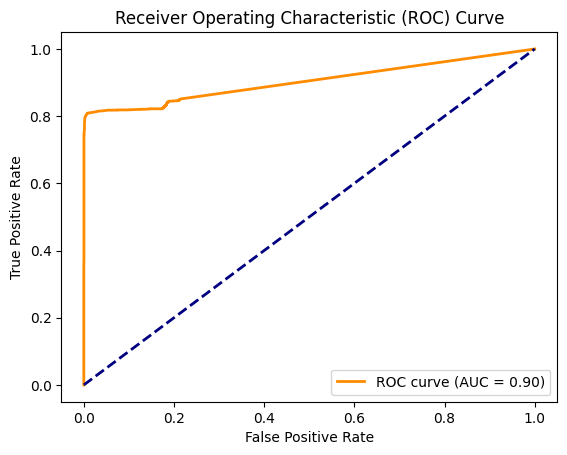

Test score {'accuracy': 0.9004771642808452, 'precision': 0.9906510851419031, 'auc': 0.9029475663232905, 'f1': 0.8904561824729892, 'aupr': 0.9189341548199839, 'recall': 0.8086672117743254}


In [12]:
y_pred_test = model.predict(x_test_)

from sklearn import metrics
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
 
def evaluate_classification_binary(y_test, y_pred, y_pred_score=None):
    accuracy = accuracy_score(y_test, y_pred)
    if y_pred_score is None:
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    else:
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_score, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    f1 = metrics.f1_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    logging.info(metrics.classification_report(y_test, y_pred))
    from sklearn.metrics import average_precision_score
    aupr = average_precision_score(y_test, y_pred_score)
    score = {}
    score['accuracy'] = accuracy
    score['precision'] = precision
    score['auc'] = auc
    score['f1'] = f1
    score['aupr'] = aupr
    score['recall'] = recall

    # plot auc curve
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')

    # Save the ROC plot
    plt.savefig('roc_curve.png')

    # Show the ROC plot
    plt.show()

    return score

if hasattr(model, 'predict_proba'):
    y_pred_test_scores = model.predict_proba(x_test_)[:, 1]
else:
    y_pred_test_scores = y_pred_test

test_score = evaluate_classification_binary(y_test_, y_pred_test, y_pred_test_scores)

logging.info('Test score {}'.format(test_score))



In [13]:
# !python analysis/run_it_all.py

model_name = 'P-net'

# save prediction data for plot generation

def save_prediction(info, y_pred, y_pred_scores, y_test, model_name, training=False):

        if training:
            file_name = join(model_name + '_training.csv')
        else:
            file_name = join(model_name + '_testing.csv')
        info = pd.DataFrame(index=info)
        print(('info', info))
        print(y_test)
        info['pred'] = y_pred
        info['pred_scores'] = y_pred_scores

        # survival case
        # https://docs.scipy.org/doc/numpy/user/basics.rec.html
        if y_test.dtype.fields is not None:
            fields = y_test.dtype.fields
            for f in fields:
                info['y_{}'.format(f)] = y_test[f]
        else:
            info['y'] = y_test
        info.to_csv(file_name)

save_prediction(info_t, y_pred_test, y_pred_test_scores, y_test_, model_name)

# save model

filename = '/PROJECTS/Sally/PNET_py3_enh_gene/_logs/enh_vs_genes/log/fs/P-net.h5'

# filename = join(log_dir, 'fs')
# filename = join(filename, model_name + '.h5')
# # if not exists(filename.strip()):
# #     makedirs(filename)

# save model weights 

w_filename = '/PROJECTS/Sally/PNET_py3_enh_gene/_logs/enh_vs_genes/log/fs/P-net_weights.h5'

# model.save_model(w_filename)

# load model 


#load model weights

# model = model.load_model(w_filename)



('info', Empty DataFrame
Columns: []
Index: [19, 138, 170, 183, 219, 274, 409, 909, 959, 1023, 1042, 1056, 1070, 1092, 1308, 1320, 1543, 1559, 1861, 1924, 2063, 2126, 2267, 2499, 2585, 2593, 2600, 2604, 2605, 2607, 2611, 2672, 3102, 3160, 3225, 3375, 3386, 3390, 3391, 3396, 3417, 3418, 3422, 3438, 3462, 3994, 3995, 3997, 4005, 4008, 4171, 4318, 4352, 4457, 4461, 4465, 4490, 4550, 4716, 4739, 4791, 4942, 4944, 5032, 5121, 5137, 5174, 5262, 5338, 5822, 6246, 6289, 6380, 6409, 6608, 6909, 7083, 7100, 7108, 7299, 7388, 7545, 7572, 7672, 7787, 7899, 7918, 8054, 8482, 9176, 9297, 9330, 9384, 9575, 9725, 9755, 9860, 9899, 9911, 9926, ...]

[7335 rows x 0 columns])
NA
19        0
138       0
170       0
183       0
219       0
         ..
619048    1
619051    0
619066    0
619068    1
619077    0
Name: response, Length: 7335, dtype: int64


52/52 [==============================] - 0s 5ms/step
(1662, 1)
52/52 [==============================] - 0s 5ms/step
(1662, 1)
52/52 [==============================] - 0s 5ms/step
(1662, 1)
52/52 [==============================] - 0s 5ms/step
(1662, 1)
52/52 [==============================] - 0s 5ms/step
(1662, 1)
52/52 [==============================] - 0s 5ms/step
(1662, 1)
52/52 [==============================] - 0s 6ms/step
(1662, 1)
52/52 [==============================] - 0s 5ms/step
(1662, 1)
52/52 [==============================] - 0s 5ms/step
(1662, 1)
52/52 [==============================] - 0s 5ms/step
(1662, 1)
52/52 [==============================] - 0s 5ms/step
(1662, 1)
52/52 [==============================] - 0s 5ms/step
(1662, 1)
52/52 [==============================] - 0s 5ms/step
(1662, 1)
52/52 [==============================] - 0s 6ms/step
(1662, 1)
52/52 [==============================] - 0s 5ms/step
(1662, 1)
52/52 [==============================] - 0s 5ms/step
(1

PermutationExplainer explainer: 2it [1:09:31, 4171.69s/it]           


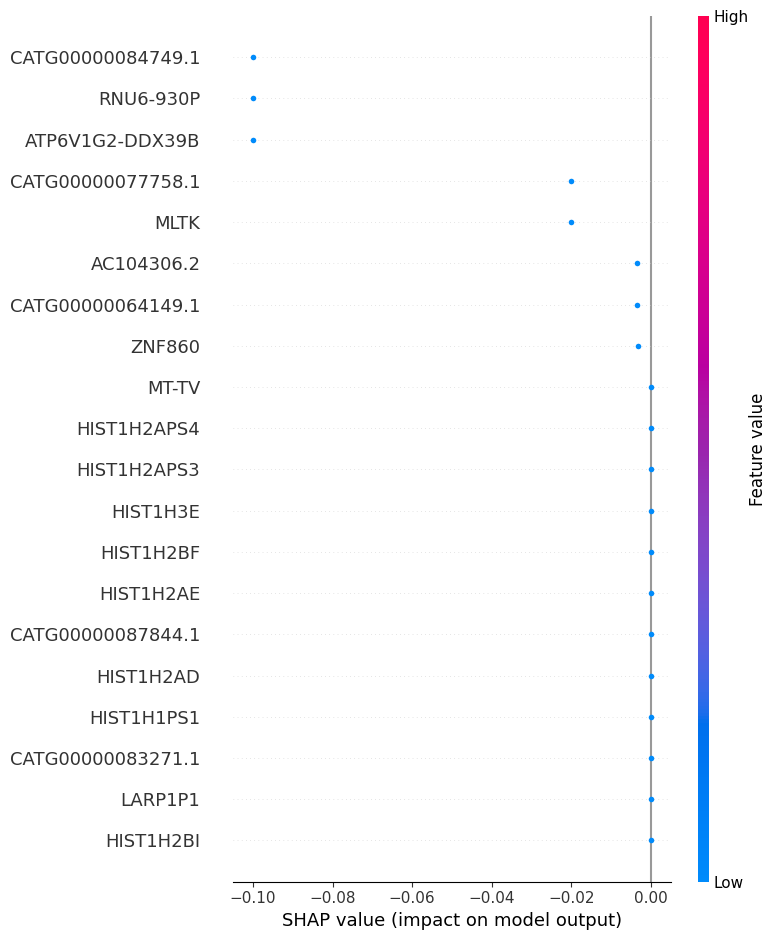

In [67]:
# shap implementation

import shap   
from tensorflow.keras.models import load_model, model_from_json

sample = x_test_[1:11]

# sample_output = model.predict(sample)

# # Find the indices where the value is 1
# indices_of_ones = np.where(sample_output == 1)[0]

# # Print the indices
# print("Indices of '1':", indices_of_ones)

# print('sample_output:', sample_output)

from config_path import INTERACTIONS_PATH

gene_names = join(INTERACTIONS_PATH, 'enh_vs_genes_selected_genes.csv')

# Read the CSV file
df = pd.read_csv(gene_names)

# Extract gene names into a list
genes_list = df['genes'].tolist()

explainer = shap.Explainer(model, x_test_)
shap_values = explainer.shap_values(sample)
shap.summary_plot(shap_values, sample, feature_names=genes_list)





In [60]:
# shap.plots.force(explainer.expected_value, shap_values)

Int64Index([    19,    138,    170,    183,    219,    274,    409,    909,
               959,   1023,
            ...
            612524, 612732, 612836, 612921, 612995, 619048, 619051, 619066,
            619068, 619077],
           dtype='int64', name='NA', length=7335)
